In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


In [ ]:
db_path = Path(settings.path.processed, 'norther.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_672768/1054908431.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)


<Axes: xlabel='timestamp'>

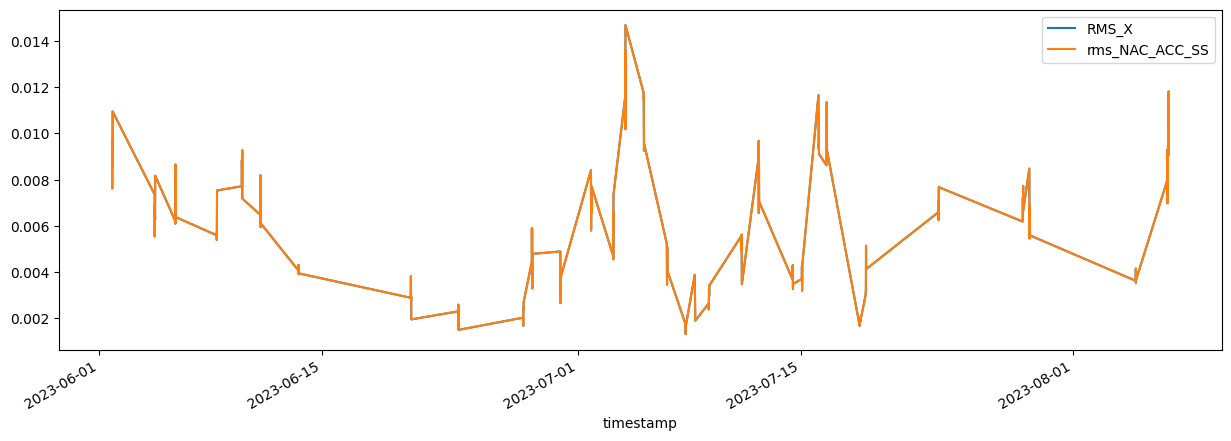

In [5]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


# synchronization check == > yes

In [6]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics = get_statistic(db_path,['Welch_X', 'Welch_Y', 'Welch_Z', 'RollingAverage_X', 'RollingAverage_Y', 'RollingAverage_Z'],
              [np.max,np.min,np.std,np.mean], 'processed_data',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics)



                Statistics Table                
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Column Name      ┃ Statistic ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Welch_X          │ max       │      4.191697 │
│ Welch_X          │ min       │    -18.741716 │
│ Welch_X          │ std       │    -0.9837241 │
│ Welch_X          │ mean      │    -3.8683734 │
│ Welch_Y          │ max       │      4.869997 │
│ Welch_Y          │ min       │    -19.199324 │
│ Welch_Y          │ std       │    -1.4130867 │
│ Welch_Y          │ mean      │     -3.827928 │
│ Welch_Z          │ max       │   -0.17400934 │
│ Welch_Z          │ min       │    -18.453154 │
│ Welch_Z          │ std       │     -5.803719 │
│ Welch_Z          │ mean      │    -7.3886003 │
│ RollingAverage_X │ max       │   0.076331586 │
│ RollingAverage_X │ min       │   -0.07509273 │
│ RollingAverage_X │ std       │   0.006984314 │
│ RollingAverage_X │ mean      │ 6.8863737e-09 │
│ RollingAverage_Y │ max       │    0.09320284 │
│ RollingAverage_Y │ min       │   -0.09582217 │
│ RollingAverage_Y │ std       │  0.0063185487 │
│ RollingAverage_Y │ mean      │  9.452088e-09 │
│ RollingAverage_Z │ max       │    0.01842118 │
│ RollingAverage_Z │ min       │  -0.012660166 │
│ RollingAverage_Z │ std       │ 0.00070675137 │
│ RollingAverage_Z │ mean      │  8.574571e-10 │
└──────────────────┴───────────┴───────────────┘

In [7]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,['DEM5_TP_SG_LAT014_Mtn','mean_windspeed'],
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)



                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
│ mean_windspeed        │ max       │      23.4941 │
│ mean_windspeed        │ min       │       0.4712 │
│ mean_windspeed        │ std       │       4.2531 │
│ mean_windspeed        │ mean      │       9.0622 │
└───────────────────────┴───────────┴──────────────┘

In [8]:
statistics_scada['DEM']= statistics_scada['DEM5_TP_SG_LAT014_Mtn']

In [9]:
statistics.update(statistics_scada)

# statistics make sense == > yes

In [10]:
from src.model.prepared_queries import simple_view, do_nothing
from src.model.transformation import EncoderBasedOnList
columns = ["Welch_X", "Welch_Y", "Welch_Z"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]*3
freq_axis_masked = transform_func[0][1].freq_axis_masked
transform_func[0]
key_query  = f"""SELECT id FROM processed_data 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'


"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing, 
    view_table_name='processed_data',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=128,
    cached=True,
    return_dict=True
)


In [11]:
data_loader.setup()
for b in data_loader.train_dataloader():
    print(b['Welch_X'].shape)
    break

torch.Size([128, 492])


In [12]:
from src.model.backbone.VAE import TrainingMultiHeadVAE
from src.model.backbone.VQ_VAE import TrainingMultiHeadVQVAE
from src.model.backbone.AE import TrainingMultiHeadAE
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
torch.set_float32_matmul_precision("high")
# Initialize the model
vae_model = TrainingMultiHeadAE(
    input_spec={'Welch_X': 492, 'Welch_Y': 492, 'Welch_Z': 492},
    latent_dim=32,
    separated_layer=[128],
    shared_layer=[128],
    activation_str='relu',
    batch_norm=False,
    normalization_values=statistics,
    lr=5e-3
)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="vae-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=150,
    accelerator='gpu',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
)

# Train the model
trainer.fit(vae_model, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type                 | Params | Mode 
---------------------------------------------------------
0 | model   | MultiHeadAutoEncoder | 486 K  | train
1 | loss_fn | MSELoss              | 0      | train
---------------------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K 

Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
best_ae_path = Path(checkpoint_callback.best_model_path)
model_ae =TrainingMultiHeadAE.load_from_checkpoint(best_ae_path)


In [14]:
Path('/home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/vae-epoch=149-val_loss=0.96.ckpt')

PosixPath('/home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints/vae-epoch=149-val_loss=0.96.ckpt')

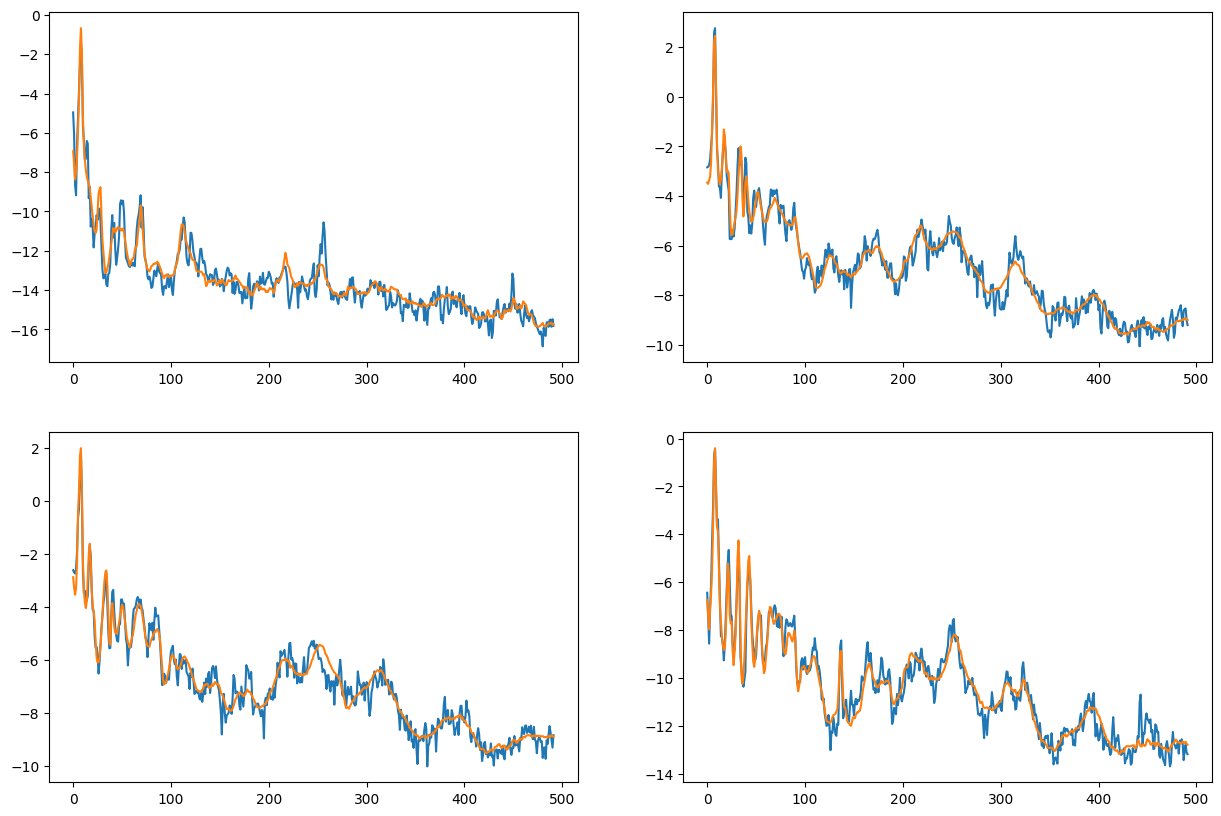

In [15]:
model_ae.to('cpu')
data = next(iter(data_loader.train_dataloader()))

data_rec = model_ae(data) 
data = data['Welch_X']
data_rec = data_rec['reconstruction']['Welch_X']
fig,ax  = plt.subplots(2,2,figsize=(15,10))
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot( psd_in.cpu().numpy())
    ax[i//2, i%2].plot( psd_out.cpu().detach().numpy())
plt.show()


In [16]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ['Welch_X','Welch_Y','Welch_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+4*[ToTensor()]+ [nn.Identity()] + [EncoderBasedOnList(settings.norther.turbine_list.to_list())]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem 
WHERE Turbine_name IN ('{"','".join(fleet_leaders[:5])}')
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096,
    cached=True,
    return_dict=True
)
data_loader_dem.setup() 

In [17]:
dfs = []
for batch in data_loader_dem.all_dataloader():
    model_ae.eval()
    #b['Welch'] = b['Welch_X']
    batch = {k: v.to(model_ae.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

    with torch.no_grad():
        enc = model_ae(batch)
    mu = enc['latent_layer']
    df_temp = pd.DataFrame({'mean_windspeed':batch['mean_windspeed'].cpu().numpy(),
                            'mean_power':batch['mean_power'].cpu().numpy(),
                            'mean_pitch':batch['mean_pitch'].cpu().numpy(),
                            'mean_rpm':batch['mean_rpm'].cpu().numpy(),
                            'caseID':batch['caseID'],
                            'embedding':[e.cpu().numpy() for e in mu],
                            'turbine_name':batch['turbine_name']})
    dfs.append(df_temp)
df = pd.concat(dfs)

In [18]:
df['caseID']=df['caseID'].apply(lambda x: x.split(':')[0])

In [19]:
definitions = settings.case_definitions.to_list()
caseid_to_parent_first = {definition['name']: definition['parent_class'][0] for definition in definitions}
caseid_to_parent_first['Missing SCADA'] = "Missing SCADA"
df['ParentCase'] = df['caseID'].map(caseid_to_parent_first)
df['turbine_name'].unique()


array([ 8, 10, 22, 28, 38])

In [20]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import umap
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
sns.set(style="whitegrid")

# Assuming df is your DataFrame and it now contains 'ParentCase' column

# 1. Encode ParentCase as numeric labels
label_encoder = LabelEncoder()
df['ParentCase_encoded'] = label_encoder.fit_transform(df['ParentCase'])

# Retrieve the mapping of encoded labels to original ParentCase labels
encoded_labels = df['ParentCase_encoded'].unique()
original_labels = label_encoder.inverse_transform(encoded_labels)
label_mapping = dict(zip(encoded_labels, original_labels))

# 2. Combine all embeddings into a numpy array for turbine_name == 28

# Ensure that 'embedding' column contains iterable sequences (e.g., lists or arrays)
# Replace the following line with actual embeddings extraction
# embeddings = np.vstack(df_turb['embedding'].apply(np.array).values)
embeddings = np.vstack(df['embedding'].values)

# Apply t-SNE or UMAP for dimensionality reduction if needed
# Uncomment and use one of the following as per your requirement

# Example using t-SNE:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Example using UMAP:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

# For demonstration, let's assume embeddings_2d is already 2D
# Replace this with actual dimensionality reduction if applied
#embeddings_2d = embeddings  # Replace with actual reduced embeddings

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# turn the embeddings into a dataframe where each row and column is a list of the embeddings 
df_embendings = pd.DataFrame(embeddings_2d, columns=['x', 'y'])


In [22]:
df.reset_index(drop=True, inplace=True)

In [23]:
df = pd.concat([df, df_embendings], axis=1)

In [24]:
df

,mean_windspeed,mean_power,mean_pitch,mean_rpm,caseID,embedding,turbine_name,ParentCase,ParentCase_encoded,x,y
0,1.9870,-93.989601,20.0000,0.0000,Missing SCADA,"[0.260047, 0.577149, -1.7200361, -0.47334045, ...",8,Missing SCADA,1,15.071533,5.910598
1,2.8262,-93.189400,20.0000,0.0000,Missing SCADA,"[0.34647283, 0.322262, -1.6546286, -0.5196388,...",8,Missing SCADA,1,15.247115,5.663788
2,3.7727,-95.659401,20.0000,0.5000,Missing SCADA,"[0.39816514, 0.43513572, -1.7380471, -0.412977...",8,Missing SCADA,1,14.931003,6.170592
3,4.4882,-93.429398,20.0000,1.0100,Missing SCADA,"[0.21186447, 0.41814563, -1.4398102, -0.400211...",8,Missing SCADA,1,14.647604,6.142439
4,5.2510,-69.823997,3.0875,3.0356,"Cutin, Power < 0","[-0.1559836, 0.76080656, -0.3810094, 0.0560451...",8,Operational,2,8.620340,4.666775
...,...,...,...,...,...,...,...,...,...,...,...
13851,10.6615,6495.629883,-2.8534,10.4702,"RPM, Power < Max","[-0.40927762, -0.226972, 0.97762436, -0.466690...",38,Operational,2,-2.749631,3.017227
13852,8.4023,3748.653320,-2.4595,9.6039,"RPM, Power < Max","[-0.22380137, 0.307337, 0.8174544, 0.15289655,...",38,Operational,2,-1.460752,3.326803
13853,8.1225,3147.772705,-2.3929,9.0667,"RPM, Power < Max","[-0.17115597, 0.518396, 0.93778574, -0.1974125...",38,Operational,2,-0.833052,3.484028
13854,8.1030,3206.650146,-2.3770,9.0604,"RPM, Power < Max","[-0.16348276, 0.35081637, 0.84160703, 0.012865...",38,Operational,2,-0.808991,3.533586


In [25]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = 13
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['axes.unicode_minus'] = False

In [26]:
import matplotlib.pyplot as plt
plt.rcdefaults()

/tmp/ipykernel_672768/295986280.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


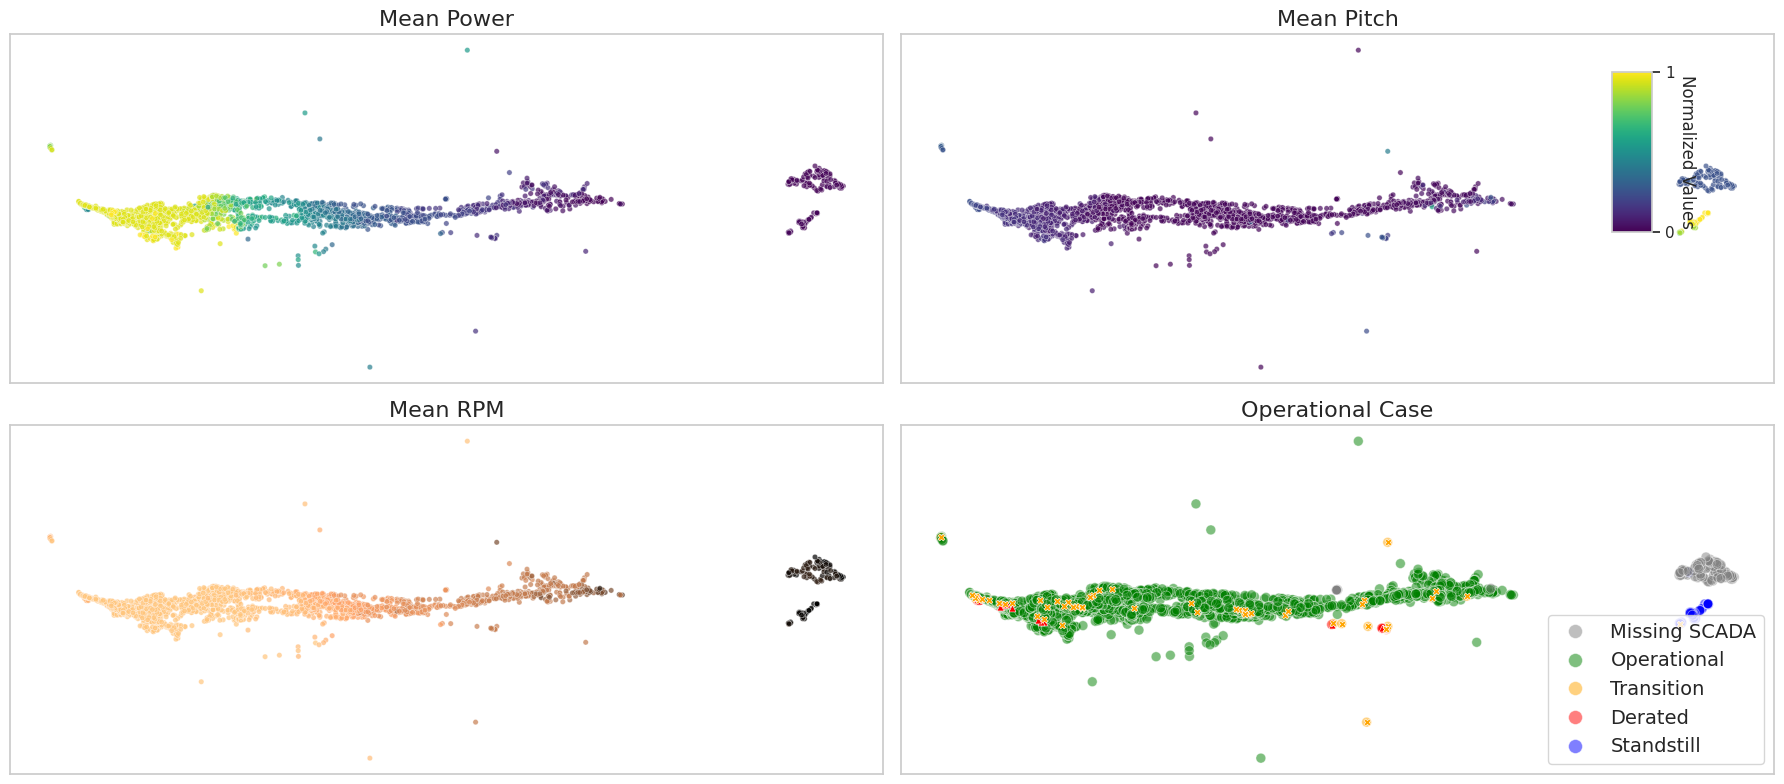

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Extract embeddings for dimensionality reduction

df_turb = df[df['turbine_name'] ==8]
# Begin plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(2, 2, figsize=(20, 8))

# Mean Power plot
sc1 = sns.scatterplot(
    data=df_turb,
    x='x',
    y='y',
    hue='mean_power',
    palette="viridis",
    ax=ax[0, 0],
    legend=False,
    s=15,
    alpha=0.7)

ax[0, 0].set_title("Mean Power",fontsize=16)

# Mean Pitch plot
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
sns.scatterplot(
    data=df_turb,
    x='x',
    y='y',
    hue='mean_pitch',
    palette="viridis",
    ax=ax[0, 1],
    legend=False,
    s=15,
    alpha=0.7
)
ax[0, 1].set_title("Mean Pitch",fontsize=16)


# Add a colorbar for Mean Pitch
cbar_ax = fig.add_axes([0.81, 0.7, 0.02, 0.2])  # Adjust position and size of the colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label("Normalized Values", rotation=270, labelpad=15)
cbar.set_ticks([0, 1])
cbar.ax.set_yticklabels(['0', '1'])

# Mean RPM plot
sns.scatterplot(
    data=df_turb,
    x='x',
    y='y',
    hue='mean_rpm',
    palette="copper",
    ax=ax[1, 0],
    legend=False,
    s=15,
    alpha=0.7
)
ax[1, 0].set_title("Mean RPM",fontsize=16)


# ParentCase plot
custom_palette = {
    "Missing SCADA": "grey",
    "Operational": "green",
    "Transition": "orange",
    "Derated": "red",
    "Standstill": "blue",
}

sns.scatterplot(data=df_turb,
    x='x',
    y='y',
    hue='ParentCase',
    palette=custom_palette,
    ax=ax[1, 1],
    s=50,
    alpha=0.5
)
# plot derated points with a different marker 
df_derated = df_turb[df_turb['ParentCase'] == 'Derated']
sns.scatterplot(data=df_derated,
    x='x',
    y='y',
    color='red',
    marker='^',
    s=25,
    ax=ax[1, 1],
    label='Derated'
)
df_transition = df_turb[df_turb['ParentCase'] == 'Transition']
sns.scatterplot(data=df_transition,
    x='x',
    y='y',
    color='orange',
    marker='X',
    s=25,
    ax=ax[1, 1],
    label='Transition'
)
# remove the legend for the derated points
handles, labels = ax[1, 1].get_legend_handles_labels()
# remove redundant labels
for i in range(len(labels)):
    # if the label is already in the handles, remove it
    if labels[i] in labels[:i]:
        labels[i] = ""
# remove the empty labels
labels = [label for label in labels if label != ""]
# remove the empty handles
handles = [handle for handle, label in zip(handles, labels) if label != ""]
#increase the size of the legend markers
for handle in handles:
    handle.set_markersize(10.0)
ax[1, 1].legend(handles=handles, labels=labels, loc='lower right',fontsize=14)    

ax[1, 1].set_title("Operational Case",fontsize=16)
ax[1, 1].set_xlabel("embedding (dimension 1)")
for i in range(4):
    # remove the x and y axis labels and ticks 
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_xlabel("")
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])
    


plt.tight_layout(rect=[0, 0, 0.9, 1])
# save the figure

#plt.savefig('embedding_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_672768/793434163.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_turb['ParentCaseNum'] = df_turb['ParentCase'].map(parentcase_mapping)


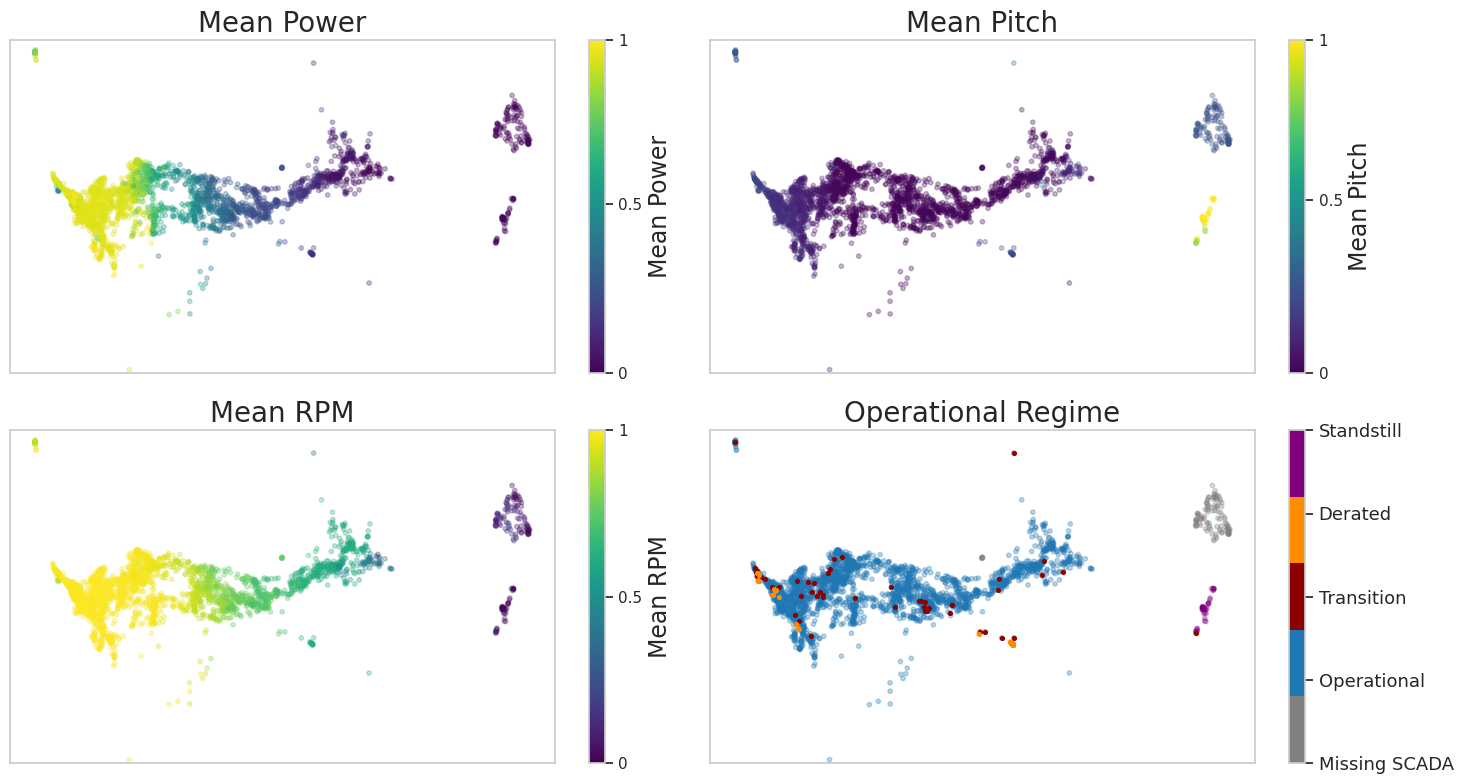

In [28]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Plot the t-SNE projection with color bars for each plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

df_turb = df[df['turbine_name'] ==8]
# Mean Power plot
norm1 = Normalize(vmin=df_turb.mean_power.min(), vmax=df_turb.mean_power.max())
sc1 = ax[0, 0].scatter(
    df_turb['x'], df_turb['y'], 
    c=norm1(df_turb['mean_power']), 
    cmap="viridis", 
    s=10, alpha=.3
)
ax[0, 0].set_title('Mean Power',fontsize=20)
ax[0,0].set_ylim([0,8])
sm1 = cm.ScalarMappable(cmap='viridis', norm=norm1)
sm1.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm1, ax=ax[0, 0])
cbar.ax.set_ylabel(ylabel='Mean Power', fontsize=17)
cbar.set_ticks([df_turb.mean_power.min(), df_turb.mean_power.max()/2, df_turb.mean_power.max()])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

# Mean Pitch
norm3 = Normalize(vmin=df_turb.mean_pitch.min(), vmax=df_turb.mean_pitch.max())
sc3 = ax[0, 1].scatter(
    df_turb['x'], df_turb['y'],
    c=norm3(df_turb.mean_pitch), cmap='viridis', s=10, alpha=.3
)
ax[0, 1].set_title('Mean Pitch',fontsize=20)
ax[0,1].set_ylim([0,8])
sm2 = cm.ScalarMappable(cmap='viridis', norm=norm3)
sm2.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm2, ax=ax[0, 1], label='Mean Pitch')
cbar.ax.set_ylabel(ylabel='Mean Pitch', fontsize=17)
cbar.set_ticks([df_turb.mean_pitch.min(), df_turb.mean_pitch.max()/2, df_turb.mean_pitch.max()])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

# Mean RPM
norm4 = Normalize(vmin=df_turb.mean_rpm.min(), vmax=df_turb.mean_rpm.max())
sc4 = ax[1, 0].scatter(
    df_turb.x, df_turb.y,
    c=norm4(df_turb.mean_rpm), cmap='viridis', s=10, alpha=.3
)
ax[1, 0].set_title('Mean RPM',fontsize=20)
ax[1,0].set_ylim([0,8])
sm4 = cm.ScalarMappable(cmap='viridis', norm=norm4)
sm4.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm4, ax=ax[1, 0])
cbar.ax.set_ylabel(ylabel='Mean RPM', fontsize=17)
cbar.set_ticks([df_turb.mean_rpm.min(), df_turb.mean_rpm.max()/2, df_turb.mean_rpm.max()])
cbar.ax.set_yticklabels(['0', '0.5', '1'])

import matplotlib.colors as mcolors

# Define custom palette and mapping
custom_palette = {
    "Missing SCADA": "grey",
    "Operational": "tab:blue",
    "Transition": "darkred",
    "Derated": "darkorange",
    "Standstill": "purple",
}

# Map ParentCase to integers for colormap
parentcase_mapping = {key: i for i, key in enumerate(custom_palette.keys())}
df_turb['ParentCaseNum'] = df_turb['ParentCase'].map(parentcase_mapping)

# Create a colormap with the same order as custom_palette
cmap = mcolors.ListedColormap(custom_palette.values())

# Scatter plot with numerical mapping
sc5 = ax[1, 1].scatter(
    df_turb['x'], df_turb['y'], 
    c=df_turb['ParentCaseNum'], 
    cmap=cmap, 
    s=10, alpha=0.3
)

# Create a ScalarMappable for the colorbar without alpha
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(custom_palette) - 1))
sm.set_array([])  # Required for ScalarMappable

# Add the colorbar without alpha
cbar = fig.colorbar(sm, ax=ax[1, 1])
cbar.set_ticks(list(parentcase_mapping.values()))
cbar.set_ticklabels(list(custom_palette.keys()))
cbar.ax.tick_params(labelsize=13)

ax[1, 1].set_title('Operational Regime',fontsize=20)
ax[1,1].set_ylim([0,8])

df_transition = df_turb[df_turb['ParentCase'] == 'Transition']
ax[1,1].scatter(data=df_transition,
    x='x',
    y='y',
    color='darkred',
    s=7,
    label='Transition'
)
# plot derated points with a different marker 
df_derated = df_turb[df_turb['ParentCase'] == 'Derated']
ax[1,1].scatter(data=df_derated,
    x='x',
    y='y',
    color='darkorange',
    s=7,
    label='Derated'
)

for i in range(4):
    # remove the x and y axis labels and ticks 
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_xlabel("")
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])

#cbar.ax.set_yticklabels([label_mapping[i] for i in range(len(label_mapping))])


# Adjust layout and show plot
plt.tight_layout()
plt.savefig('embedding_plot.png', dpi=300)
plt.show()

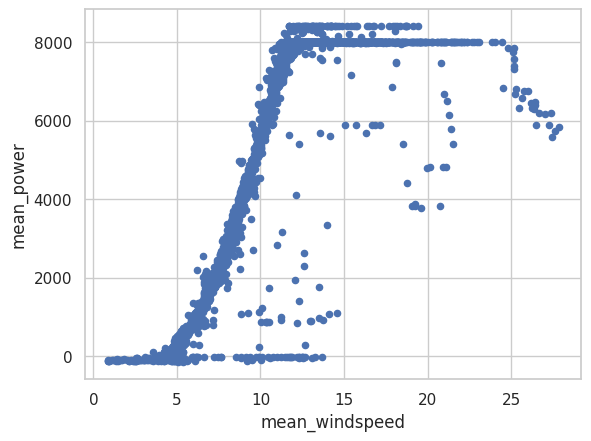

In [29]:
df_turb.plot('mean_windspeed','mean_power','scatter')
plt.show()

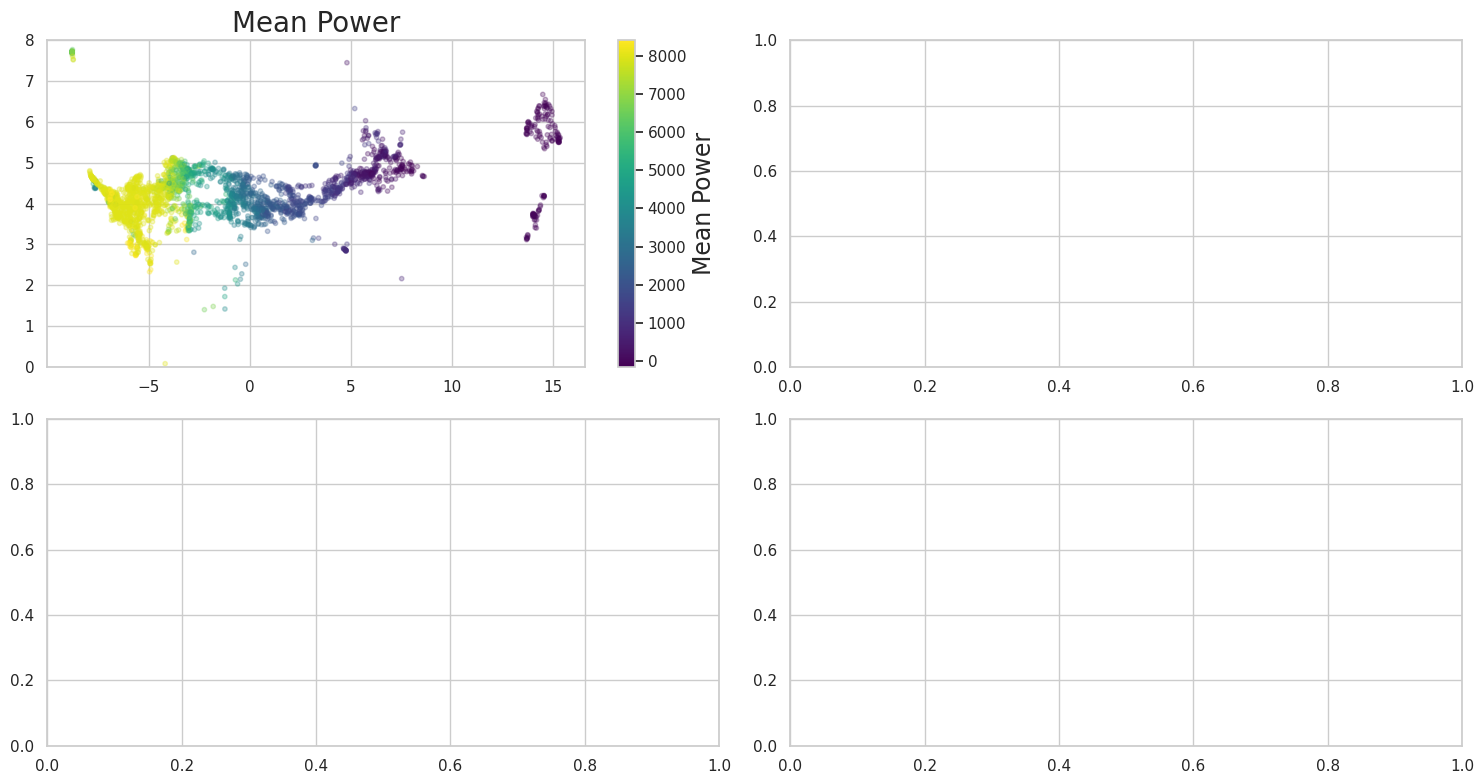

In [30]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Plot the t-SNE projection with color bars for each plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

df_turb = df[df['turbine_name'] == 8]

# Mean Power plot
norm1 = Normalize(vmin=df_turb.mean_power.min(), vmax=df_turb.mean_power.max())  # Changed to mean_power
sc1 = ax[0, 0].scatter(
    df_turb['x'], df_turb['y'], 
    c=df_turb['mean_power'],  # Changed to mean_power
    cmap="viridis", 
    s=10, alpha=.3
)
ax[0, 0].set_title('Mean Power', fontsize=20)  # Changed to 'Mean Power'
ax[0, 0].set_ylim([0, 8])

# Create ScalarMappable for the colorbar
sm1 = cm.ScalarMappable(cmap='viridis', norm=norm1)
sm1.set_array([])  # Required for ScalarMappable

# Add colorbar with label
cbar = fig.colorbar(sm1, ax=ax[0, 0])
cbar.ax.set_ylabel('Mean Power', fontsize=17)  # Changed to 'Mean Power'

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig('embedding_plot.png', dpi=300)
plt.show()


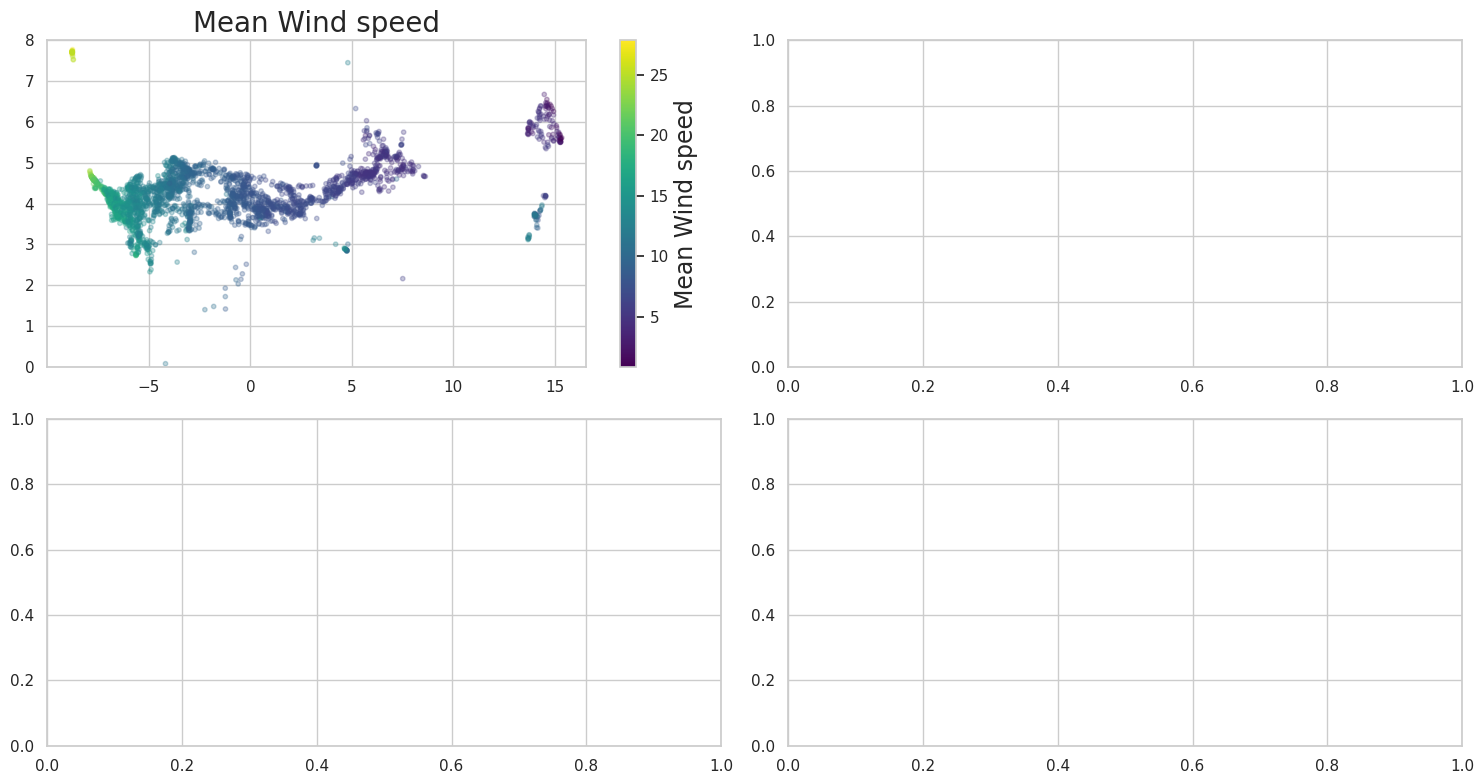

In [31]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Plot the t-SNE projection with color bars for each plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

df_turb = df[df['turbine_name'] ==8]
# Mean Power plot
norm1 = Normalize(vmin=df_turb.mean_windspeed.min(), vmax=df_turb.mean_windspeed.max())
sc1 = ax[0, 0].scatter(
    df_turb['x'], df_turb['y'], 
    c=df_turb['mean_windspeed'], 
    cmap="viridis", 
    s=10, alpha=.3
)
ax[0, 0].set_title('Mean Wind speed',fontsize=20)
ax[0,0].set_ylim([0,8])
sm1 = cm.ScalarMappable(cmap='viridis', norm=norm1)
sm1.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm1, ax=ax[0, 0])
cbar.ax.set_ylabel(ylabel='Mean Wind speed', fontsize=17)



#cbar.ax.set_yticklabels([label_mapping[i] for i in range(len(label_mapping))])


# Adjust layout and show plot
plt.tight_layout()
#plt.savefig('embedding_plot.png', dpi=300)
plt.show()

In [32]:
df_turb['y'].min()

np.float32(-3.9606798)

In [33]:
from src.data import datamodule as dm
from src.model.transformation import ToTensor

# Suppose your columns now include the PSDs *and* the target DEM
train_columns = [
    "Welch_X", "Welch_Y", "Welch_Z",  # your PSD inputs
    "turbine_name",
    "DEM"  # the target variable for regression
]
train_transforms = [
    nn.Sequential(FromBuffer(), CutPSD(frequency_axis, (0, 15)), LogTransform()),  # for Welch_X
    nn.Sequential(FromBuffer(), CutPSD(frequency_axis, (0, 15)), LogTransform()),  # for Welch_Y
    nn.Sequential(FromBuffer(), CutPSD(frequency_axis, (0, 15)), LogTransform()),  # for Welch_Z
    EncoderBasedOnList(settings.norther.turbine_list.to_list()),                  # for turbine_name
    ToTensor()                                                                     # for DEM
]

key_query = f"""
SELECT id 
FROM dem
WHERE turbine_name IN ('{"','".join(fleet_leaders[:2])}')
  AND timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'
  AND DEM IS NOT NULL
"""

data_loader_reg = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all,    # or any custom query that fetches Welch_*, DEM
    view_table_name='dem',
    key_query=key_query,
    key_name='id',
    columns=train_columns,
    transform_func=train_transforms,
    batch_size=248,
    cached=True,
    return_dict=True
)

data_loader_reg.setup()


In [34]:
len(data_loader_reg.train_dataset)

1548

In [35]:
for b in data_loader_reg.train_dataloader():
    print(b['DEM'].shape)
    break

torch.Size([248])


In [36]:
statistics['DEM']

{'max': np.float64(5475700.267833055),
 'min': np.float64(107433.06492677252),
 'std': np.float64(743985.8472242401),
 'mean': np.float64(1401611.8457079045)}

In [37]:
settings.path


<Box: {'raw': '/media/owilab/7759343A6EC07E1C', 'processed': '//home/owilab/Documents/YacineB/Code/damage_prediction_AE/data/processed', 'mlflow': '//home/owilab/Documents/YacineB/Code/damage_prediction_AE/logs/mlflow', 'tensorboard': '//home/owilab/Documents/YacineB/Code/damage_prediction_AE/logs/tensorboard', 'scada': '//home/owilab/Documents/YacineB/Code/damage_prediction_AE/data/raw'}>

In [38]:
from src.model.backbone.regressor import TrainRegressor
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

best_vae_ckpt = best_ae_path.as_posix()

regressor_model = TrainRegressor(input_spec={'latent_layer': 32},
                                 hidden_dims=[32],
                                 activation='relu',
                                 dropout=0.0,
                                 batch_norm=True,
                                 normalization_values=statistics,
                                 lr=5e-3,
                                 output_key='DEM',
                                 lr_encoder=None,
                                 vae_checkpoint=best_vae_ckpt)

checkpoint_reg_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints_regressor/",
    filename="regressor-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)
early_stop_reg_callback = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min"
)
tensorboard_logger = pl.loggers.TensorBoardLogger(settings.path.tensorboard) 

trainer_reg = pl.Trainer(
    max_epochs=500, 
    accelerator="gpu",
    devices=1,  # or "auto"
    callbacks=[checkpoint_reg_callback, early_stop_reg_callback],
    logger=tensorboard_logger,
)

trainer_reg.fit(regressor_model, data_loader_reg)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/owilab/Documents/YacineB/Code/damage_prediction_AE/checkpoints_regressor exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | vae       | TrainingMultiHeadAE | 486 K  | train
1 | regressor | MLPRegressor        | 1.2 K  | train
2 | loss_fn   | MSELoss             | 0      | train
----------------------------------------------------------
488 K     Trainable params
0         Non-trainable params
488 K     Total params
1.952     Total estimated model params size (MB)
39        Modules in train mode
1         Modules in eval mode


Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [39]:

for name, parameter in regressor_model.regressor.net.named_parameters():
    if 'weight' in name:    
        # plot histogram of the parameter values
        plt.hist(parameter.detach().cpu().numpy().flatten(), bins=10, alpha=0.5, label=name)
plt.legend()

In [40]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ["timestamp","turbine_name","Welch_X","Welch_Y","Welch_Z","DEM"]
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = [nn.Identity(),EncoderBasedOnList(settings.norther.turbine_list)]+\
    3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 15)),LogTransform())]+ [ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem WHERE turbine_name in {tuple(fleet_leaders)}
AND timestamp > '{settings.norther.training_end}'"""


data_loader_dem_all = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=4096 ,
    cached=False,
    return_dict=True,
    num_workers=32
)

In [41]:
data_loader_dem_all.setup()

In [42]:
for b in data_loader_dem_all.train_dataloader():
    print(b.keys())
    break

dict_keys(['timestamp', 'turbine_name', 'Welch_X', 'Welch_Y', 'Welch_Z', 'DEM'])


In [43]:
import pandas as pd
dfs = []

# Iterate over batches from the dataloader
for batch in data_loader_dem_all.all_dataloader():
    batch = {k: v.to(regressor_model.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    # Extract relevant keys from the batch
    timestamps = batch['timestamp']
    turbine_names = batch['turbine_name']
    dem = batch['DEM']

    # Forward pass: model_all expects the batch dictionary
    with torch.no_grad():
        data = regressor_model(batch)  # batch includes all input features
    dem_pred = data['dem_pred']
    # Create a DataFrame for the current batch
    
    df_temp = pd.DataFrame({
        'timestamp': np.array(timestamps),
        'turbine_name': np.array(turbine_names),
        'dem': np.array(dem.cpu()),
        'dem_pred': dem_pred.squeeze().cpu().numpy(),
    })
    dfs.append(df_temp)

# Concatenate all batch results
data = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_672768/3756066850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_turbine['timestamp'] = pd.to_datetime(data_turbine['timestamp'])


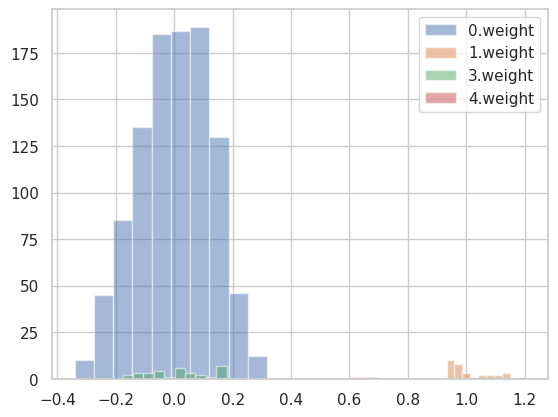

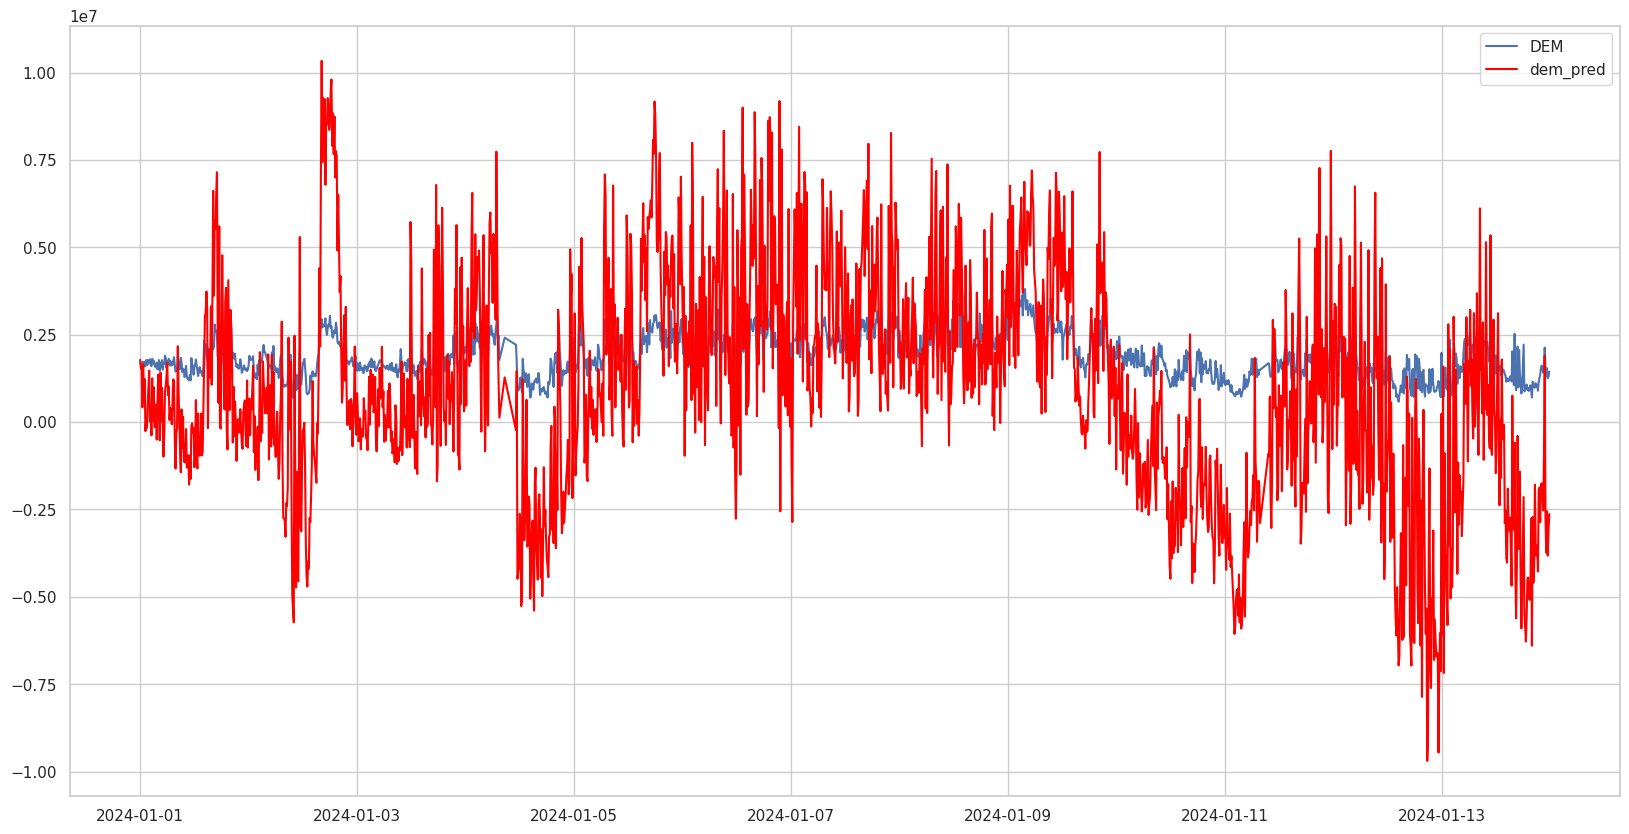

In [44]:
data = pd.concat(dfs).query("'2024-01-01' <= timestamp <= '2024-01-14'")
data_turbine = data[data['turbine_name'] == 8]
data_turbine['timestamp'] = pd.to_datetime(data_turbine['timestamp'])
fig , ax = plt.subplots( figsize=(20,10))
ax.plot(data_turbine['timestamp'], data_turbine['dem'], label='DEM')
ax.plot(data_turbine['timestamp'], data_turbine['dem_pred'], label='dem_pred',color='red')
ax.legend()

plt.show()


In [45]:
from src.evaluation.metric import r2_score, relative_err

In [46]:
pd.concat(dfs).groupby('turbine_name').apply(lambda x: r2_score(x['dem'], x['dem_pred']))

/tmp/ipykernel_672768/4124651593.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd.concat(dfs).groupby('turbine_name').apply(lambda x: r2_score(x['dem'], x['dem_pred']))


turbine_name
8    -21.134592
10   -19.971663
22   -20.833082
28   -17.563025
38   -18.737892
dtype: float32

In [47]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Resample or group by hourly buckets.
#    Below, we group by BOTH turbine_name and 1-hour timestamps and compute mean:
df_hourly = (
    df.groupby([
        'turbine_name',
        pd.Grouper(key='timestamp', freq='10min')
    ])[['dem', 'dem_pred']]
    .mean()
    .reset_index()
)
from src.evaluation.metric import relative_err

# 3. Compute the overall relative error across all turbines/hours
df_hourly.groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['dem_pred']))

KeyError: 'timestamp'

In [280]:
pd.concat(dfs).groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['dem_pred']))

/tmp/ipykernel_2884436/3305031194.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd.concat(dfs).groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['dem_pred']))


turbine_name
8     0.407320
10    0.380629
22    0.333819
28    0.519429
38    0.310424
dtype: float32